# Engenharia do Conhecimento 2023/2024

## TP08: Feature Selection, Dimensionality Reduction and Model Tuning
*A Machine Learning Tutorial by Andre Falcao (DI/FCUL 2020-2022), 
*revised by Catia Pesquita (DI/FCUL 2022-2023), Luís Correia (23/24)*

### Summary

1. Feature selection
    1. Using correlation
    2. Using stepwise methods
    3. Random Forests for Feature Selection
2. Principal Components analysis
    1. Linear PCA
    2. Kernel PCA
3. Model Tuning


## 1. Feature selection

### 1.1 Correlation

We are going to start by getting our favourite libraries and our dataset arranged for Binary Classification

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

Now get the diabetes dataset

In [2]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()

# Convert to a pandas dataframe
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
# Add the target variable to the dataframe
df['target'] = diabetes.target

Let's make a simple evaluation function running 2 regression algorithms and producing the R2 for each

In [3]:
# train-test split
train, test = train_test_split(df, test_size=0.2, random_state=0)

def naive_model_testing(train, test):
    
    #test 2 models, DTs and LR, and print out the results
    dtr= DecisionTreeRegressor(max_depth=5)
    dtr.fit(train.drop('target', axis=1), train['target'])

    lmr=LinearRegression()
    lmr.fit(train.drop('target', axis=1), train['target'])

   # rf_preds=rfr.predict(X_test)
    dt_preds=dtr.predict(test.drop('target', axis=1))
    lr_preds=lmr.predict(test.drop('target', axis=1))

   # print("RVE RFs: %7.4f" % explained_variance_score(y_test, rf_preds))
    print("R2 Decision Tree Regression: %7.4f" % r2_score(test['target'], dt_preds))
    print("R2 Linear Regression: %7.4f" % r2_score(test['target'], lr_preds))

naive_model_testing(train, test)


R2 Decision Tree Regression:  0.0629
R2 Linear Regression:  0.3322


### Correlation 

As a first exercise we are going to use the Spearman correlation

In [4]:
spear = df.corr(method='spearman')
spear

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
age,1.000000,0.177463,0.200554,0.350859,0.262524,0.221711,-0.106973,0.221017,0.265176,0.296235,0.197822
sex,0.177463,1.000000,0.098079,0.261508,0.027790,0.134695,-0.394584,0.337524,0.174625,0.203277,0.037401
bmi,0.200554,0.098079,1.000000,0.397985,0.287829,0.295494,-0.371172,0.459068,0.491609,0.384664,0.561382
bp,0.350859,0.261508,0.397985,1.000000,0.275224,0.205638,-0.191033,0.280799,0.396071,0.381219,0.416241
s1,0.262524,0.027790,0.287829,0.275224,1.000000,0.878793,0.015308,0.520674,0.512864,0.332173,0.232429
s2,0.221711,0.134695,0.295494,0.205638,0.878793,1.000000,-0.197435,0.652283,0.349947,0.286483,0.195834
s3,-0.106973,-0.394584,-0.371172,-0.191033,0.015308,-0.197435,1.000000,-0.789694,-0.450420,-0.290863,-0.410022
s4,0.221017,0.337524,0.459068,0.280799,0.520674,0.652283,-0.789694,1.000000,0.640390,0.413700,0.448931
s5,0.265176,0.174625,0.491609,0.396071,0.512864,0.349947,-0.450420,0.640390,1.000000,0.453023,0.589416
s6,0.296235,0.203277,0.384664,0.381219,0.332173,0.286483,-0.290863,0.413700,0.453023,1.000000,0.350792


### Exercise 1

1. Identify the Top 5 most correlated variables to the y
2. Check if this variable selection is capable of better results than using all variables

In [5]:
# Exercise 1.1
# The 5 most correlated feature with the target are: 
#  's5' with a correlation of 0.5864, 
#  'bmi' with a correlation of 0.5613, 
#  's4' with a correlation of 0.4489,
#  'bp' with a correlation of 0.4162 and
#  's3' with a correlation of -0.4100


In [6]:
# Exercise 1.2

# It is possible to get better results, as we can see the correlation score of variable it's own is always 1.0, therefore there is no need
# to calculate the correlation of a variable with itself.
# The correlation matrix is symmetric, so we can just calculate the upper triangle of the matrix and that's all the values we need.


In [7]:
# Exercise 1.extra
# run previous cell multiple times and observe that DTs score may change.  Why? 

# The DTs score may change because the train_test_split function is splitting the data randomly, so the training and testing data 
# might be different, this is what causes the spearman coefficient to change.
# If we want to make sure that each split is the same, we can set the random_state parameter to a fixed value.

### 1.2. Stepwise Feature selection

Here we are going to use the [Sequential Feature Selector form scikit](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html#sklearn.feature_selection.SequentialFeatureSelector) which takes any supervised method and runs the forward or the backward methods for defining the most relevant variables

By default it uses the forward method and we are going to select the best 5 features

In [8]:
from sklearn.feature_selection import SequentialFeatureSelector

N, M = train.shape
M = M-1  # to have the data shape without target
print('shape: ', N, 'x', M)

shape:  353 x 10


In [9]:
#using linear regression for sequential feature selection
lmr=LinearRegression()
sfs = SequentialFeatureSelector(lmr, n_features_to_select=5).set_output(transform="pandas")
sfs.fit(train.drop('target', axis=1), train['target'])

#get the relevant columns
features=sfs.get_support()
Features_selected =np.arange(M)[features]
print("The features selected are columns: ", Features_selected)

n_train=sfs.transform(train.drop('target', axis=1))
n_test=sfs.transform(test.drop('target', axis=1))

n_train['target'] = train['target']  # form the train dataframe to pass to the metrics function
n_test['target'] = test['target']  # form the test dataframe to pass to the metrics function

naive_model_testing(n_train, n_test)

The features selected are columns:  [1 2 3 4 8]
R2 Decision Tree Regression:  0.0194
R2 Linear Regression:  0.3120


### Exercise 2

1. Run forward sequential fitting for a decision tree with max_depth=3

2. Change the direction to "backward"

In [10]:
#Exercise 2.1

# unfitted estimator
tree = DecisionTreeRegressor(max_depth=3);

sfs = SequentialFeatureSelector(tree, n_features_to_select=5, direction="forward").set_output(transform="pandas");

sfs.fit(train.drop('target', axis=1), train['target']);

#get the relevant columns
features=sfs.get_support();
Features_selected = np.arange(M)[features];
print("The features selected are columns: ", Features_selected);

n_train=sfs.transform(train.drop('target', axis=1));
n_test=sfs.transform(test.drop('target', axis=1));

n_train['target'] = train['target'];  # form the train dataframe to pass to the metrics function
n_test['target'] = test['target'];  # form the test dataframe to pass to the metrics function

naive_model_testing(n_train, n_test);

In [11]:
#Exercise 2.2

tree = DecisionTreeRegressor(max_depth=3);

sfs = SequentialFeatureSelector(tree, n_features_to_select=5, direction="backward").set_output(transform="pandas");

sfs.fit(train.drop('target', axis=1), train['target']);

#get the relevant columns
features=sfs.get_support();
Features_selected = np.arange(M)[features];
print("The features selected are columns: ", Features_selected);

n_train=sfs.transform(train.drop('target', axis=1));
n_test=sfs.transform(test.drop('target', axis=1));

n_train['target'] = train['target'];  # form the train dataframe to pass to the metrics function
n_test['target'] = test['target'];  # form the test dataframe to pass to the metrics function

naive_model_testing(n_train, n_test);

## 2. Principal Components Analysis

We are now going to use the [PCA module](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) from scikit-learn

First let's just find a 2D projection of our data (remember to use only the training set)


In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).set_output(transform="pandas") #finding the two best PCs
pca.fit(train.drop('target', axis=1))
tve=0 #total variance explained
for i, ve in enumerate(pca.explained_variance_ratio_):
    tve+=ve
    print("PC%d - Variance explained: %7.4f - Total Variance: %7.4f" % (i, ve, tve) )
print()
print("Actual Eigenvalues:", pca.singular_values_)
for i,comp in enumerate(pca.components_):
    print("PC",i, "-->", comp)
    

PC0 - Variance explained:  0.4154 - Total Variance:  0.4154
PC1 - Variance explained:  0.1402 - Total Variance:  0.5556

Actual Eigenvalues: [1.83741142 1.06757328]
PC 0 --> [ 0.23407134  0.17993547  0.31108607  0.27430238  0.33194466  0.33280716
 -0.28414879  0.42177706  0.38377357  0.33756638]
PC 1 --> [-0.06064859  0.37808356  0.17547633  0.15725858 -0.57785175 -0.47586989
 -0.47371054  0.04251347  0.03067198  0.10167466]


### Exercise 3

1. Interpret the results above. 
   
2. What is the meaning of the PC vectors?

In [13]:
# Exercise 3.1 
# The PC0 explains 40.27% of the variance and the PC1 explains 14.92% of the variance. Therefore the PC0 is more 
# important than PC1. The first PC represents the direction of the most variance, the second PC represents the
# direction of the second most variance, and so on. The cumulative variance explained by the first two PCs is 0.5519.
# The values of within the components are the values on the axis of the correspondent PC.

# Exercise 3.2 
# PCs represent the direction of variance of data. The first PC represents the direction of the most variance, 
# the second PC represents the direction of the second most variance, and so on. PC corresponding to highest 
# eigenvalue is the direction of max variance.


Now let's project the data using the principal components defined and use them for regression

In [14]:
n_train=pca.transform(train.drop('target', axis=1))
n_test=pca.transform(test.drop('target', axis=1))
n_train['target'] = train['target']  # form the train dataframe to pass to the metrics function
n_test['target'] = test['target']  # form the test dataframe to pass to the metrics function
naive_model_testing(n_train, n_test)

R2 Decision Tree Regression: -0.0039
R2 Linear Regression:  0.2593


quite poor results as expected

### A graphical view illustrated with binary classification data

We consider now the same data as a classification problem, assuming that patients with a target value of 250 or more means they have diabetes and with less that 250 they don't

In [15]:
# with binary classified instances
# target values of 250 or more indicate diabetes
yc_diabetes=np.array([int(i>=250) for i in diabetes.target]) # to be used in graphics ahead

X_train, X_test, y_train, y_test = train_test_split(diabetes.data, yc_diabetes, test_size=0.2, random_state=23)
print("training set patients with target value >=250: ", (y_train).sum())
print("training set patients with target value <250: ", len(y_train) - (y_train).sum())

training set patients with target value >=250:  45
training set patients with target value <250:  308


Let's plot the projection in 2 components 

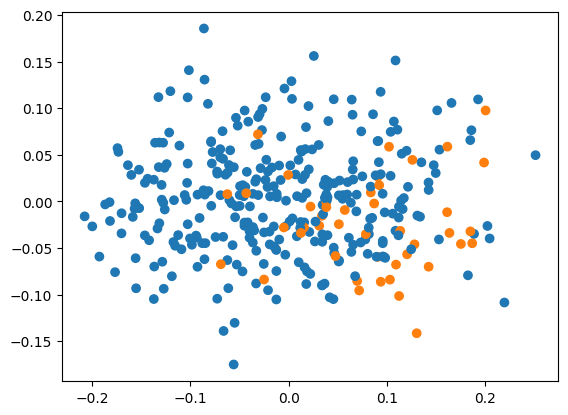

In [16]:
pca = PCA(n_components=2) #finding the two best PCs
pca.fit(X_train)
nX_train=pca.transform(X_train)
nX_test=pca.transform(X_test)
colors=np.array(["tab:blue", "tab:orange"])[y_train]
plt.scatter(nX_train[:,0], nX_train[:,1], c=colors)
plt.show()

also as a classification problem we can see it is hard to discriminate the two classes using only the two PCs

## 3. Model Tuning

For this example we are going to use Support Vector Classifiers, but any model learned so far can be used

We are going to use first [Scikit-Learn's GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), an implementation of extensive parameter search. In its basic form it just requires:
* a bare bones model constructor 
* a dictionary containing the parameters to search for. The keys of the dictionary should correspond to the parameter to test and the values to a list of possible values to test
* a scoring function defining what is the criterion to select and rank the best models
* GridSearchCV uses by default 5-Fold Cross validation, but other validation criteria can be used

The result of GridSearchCV is a structure that contains the fitted models that can then be used for learning and application

Tet's try it with the C and gamma values for support vector classification

In [17]:
from time import time
#from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import scipy.stats as stats

#make the dictionary with the testing parameters
#gammas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
#Cs = [1, 10, 100, 1e3, 1e4, 1e5]
#param_grid = {'gamma': gammas, 'C': Cs}
depths = [3, 5, 10, 15]
m_sampl_split = [2, 5, 9]
prune_a = [0.0, 0.0001, 0.001, 0.01]
param_grid = {'max_depth': depths, 'min_samples_split': m_sampl_split, 'ccp_alpha': prune_a}

#define the model and do the grid search
#clf = SVC() # RBF (Gaussian) by default
clf = DecisionTreeClassifier(criterion='log_loss', random_state=23)
gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring="f1")

start = time()
gs=gs.fit(X_train, y_train)
print(
    'GridSearchCV took %.2f seconds for %d candidate parameter settings.'
    % ((time() - start), len(gs.cv_results_['params']))
)

GridSearchCV took 0.56 seconds for 48 candidate parameter settings.


Let's identify the best element parameters [best according to the scoring function, in this case it is the F1 score]

In [18]:
#print('best gamma: %7.4f' % gs.best_estimator_.gamma)
#print('best C: %3.2f' %  gs.best_estimator_.C)
print('best maximum depth: %2.0f' % gs.best_estimator_.max_depth)
print('best minimum samples to split a node: %2.0f' %  gs.best_estimator_.min_samples_split)
print('best minimal cost pruning parameter: %1.4f' % gs.best_estimator_.ccp_alpha)

best maximum depth: 10
best minimum samples to split a node:  5
best minimal cost pruning parameter: 0.0000


Just for sake of completion, we can use the best estimator model (the one with the optimized parameters) for prediction on the test set.

In [19]:
preds=gs.best_estimator_.predict(X_test)
print('F1 : %7.4f' % f1_score(y_test, preds))
print('number of leaves:', gs.best_estimator_.get_n_leaves())

F1 :  0.4000
number of leaves: 28


GridSearchCV gives you a number of statistics on the tests it runs:

In [20]:
for i in gs.cv_results_.keys(): print(i)

mean_fit_time
std_fit_time
mean_score_time
std_score_time
param_ccp_alpha
param_max_depth
param_min_samples_split
params
split0_test_score
split1_test_score
split2_test_score
split3_test_score
split4_test_score
mean_test_score
std_test_score
rank_test_score


We can print the results in a nice Pandas Data Frame

In [21]:
grid_res = pd.DataFrame(gs.cv_results_)
grid_res.sort_values(by=['rank_test_score'], ascending=True, inplace=True) #sort the tested models by score
grid_res[['params', 'rank_test_score', 'mean_test_score', 'std_test_score', 'mean_fit_time', 'std_fit_time']] #show only mean and std of the test score

,params,rank_test_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time
34,"{'ccp_alpha': 0.001, 'max_depth': 15, 'min_sam...",1,0.374544,0.141485,0.001563,0.000465
31,"{'ccp_alpha': 0.001, 'max_depth': 10, 'min_sam...",1,0.374544,0.141485,0.001156,0.000301
7,"{'ccp_alpha': 0.0, 'max_depth': 10, 'min_sampl...",1,0.374544,0.141485,0.001311,0.000431
22,"{'ccp_alpha': 0.0001, 'max_depth': 15, 'min_sa...",1,0.374544,0.141485,0.001244,0.000331
10,"{'ccp_alpha': 0.0, 'max_depth': 15, 'min_sampl...",1,0.374544,0.141485,0.001418,0.000382
19,"{'ccp_alpha': 0.0001, 'max_depth': 10, 'min_sa...",1,0.374544,0.141485,0.001311,0.000397
43,"{'ccp_alpha': 0.01, 'max_depth': 10, 'min_samp...",7,0.335819,0.172793,0.001034,0.000063
46,"{'ccp_alpha': 0.01, 'max_depth': 15, 'min_samp...",7,0.335819,0.172793,0.001205,0.000434
23,"{'ccp_alpha': 0.0001, 'max_depth': 15, 'min_sa...",9,0.324655,0.153176,0.001287,0.000767
44,"{'ccp_alpha': 0.01, 'max_depth': 10, 'min_samp...",9,0.324655,0.153176,0.001200,0.000383


we can check if the 2nd best model produces different results 

In [22]:
print('max_depth:', grid_res.loc[1, 'param_max_depth'],
      'min_samples_split:', grid_res.loc[1, 'param_min_samples_split'],
      'ccp_alpha:', '{:.2e}'.format(grid_res.loc[1, 'param_ccp_alpha']))
clf = DecisionTreeClassifier(criterion='log_loss', random_state=23,
                             max_depth=grid_res.loc[1, 'param_max_depth'],
                             min_samples_split=grid_res.loc[1, 'param_min_samples_split'],
                             ccp_alpha=grid_res.loc[1, 'param_ccp_alpha'])
clf.fit(X_train, y_train)
preds=clf.predict(X_test)
print('F1 : %7.4f' % f1_score(y_test, preds))
print('number of leaves:', clf.get_n_leaves())

max_depth: 3 min_samples_split: 5 ccp_alpha: 0.00e+00
F1 :  0.0870
number of leaves: 8


Let's try now the RandomizedSearchCV and compare to the previous one.

In [23]:
# configure randomized search (by default also 5-fold CV)
# notice the loguniform distributions

param_dist = {
#    'C': stats.loguniform(1, 1e5),
#    'gamma': stats.loguniform(1e-7, 1e-1),
    'max_depth': stats.randint(3, 16),
    'min_samples_split': stats.randint(2, 10),
    'ccp_alpha': stats.loguniform(1e-5, 0.01)
}

n_iter_search = 15
rs = RandomizedSearchCV(
    clf, param_distributions=param_dist, n_iter=n_iter_search
)

start = time()
rs = rs.fit(X_train, y_train)
print(
    'RandomizedSearchCV took %.2f seconds for %d candidates parameter settings'
    % ((time() - start), n_iter_search)
)

RandomizedSearchCV took 0.14 seconds for 15 candidates parameter settings


In [24]:
print('best maximum depth: %2.0f' % rs.best_estimator_.max_depth)
print('best minimum samples to split a node: %2.0f' %  rs.best_estimator_.min_samples_split)
print('best minimal cost pruning parameter: %1.4f' % rs.best_estimator_.ccp_alpha)

best maximum depth:  3
best minimum samples to split a node:  9
best minimal cost pruning parameter: 0.0051


Now we can use the best estimator model (the one with the optimized parameters) for prediction

In [25]:
rs1 = rs.best_estimator_
rs1.fit(X_train, y_train)
preds=rs1.predict(X_test)
print('F1 : %7.4f' % f1_score(y_test, preds))
print('number of leaves:', rs1.get_n_leaves())

F1 :  0.0870
number of leaves: 8


In [26]:
rand_res = pd.DataFrame(rs.cv_results_)
rand_res.sort_values(by=['rank_test_score'], ascending= True, inplace=True) #sort the tested models by score
rand_res[['params', 'rank_test_score', 'mean_test_score', 'std_test_score', 'mean_fit_time', 'std_fit_time']] #show only mean and std of the test score

,params,rank_test_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time
14,"{'ccp_alpha': 0.005062812488722685, 'max_depth...",1,0.864024,0.019087,0.001158,0.000305
6,"{'ccp_alpha': 1.669181676360574e-05, 'max_dept...",2,0.844064,0.035205,0.001231,0.000427
11,"{'ccp_alpha': 0.003634277919254217, 'max_depth...",3,0.841328,0.032965,0.001349,0.000413
2,"{'ccp_alpha': 0.00017895366551472648, 'max_dep...",4,0.838431,0.026837,0.001006,0.000048
3,"{'ccp_alpha': 1.828997844774908e-05, 'max_dept...",4,0.838431,0.039856,0.001018,0.000021
4,"{'ccp_alpha': 0.00033531137942813575, 'max_dep...",6,0.838390,0.039047,0.001125,0.000451
0,"{'ccp_alpha': 1.7315805647088257e-05, 'max_dep...",7,0.835694,0.030552,0.001198,0.000394
10,"{'ccp_alpha': 0.0003664284340558954, 'max_dept...",8,0.835654,0.037807,0.001159,0.000300
13,"{'ccp_alpha': 0.00018167973326055028, 'max_dep...",8,0.835654,0.033175,0.001330,0.000421
8,"{'ccp_alpha': 0.0010418278123436517, 'max_dept...",10,0.835533,0.043056,0.001600,0.000507


checking the 2nd best model 

In [27]:
print('max_depth:', rand_res['param_max_depth'].iat[1],
      ', min_samples_split:', rand_res['param_min_samples_split'].iat[1],
      ', ccp_alpha:', '{:.2e}'.format(rand_res['param_ccp_alpha'].iat[1]))
clf = DecisionTreeClassifier(criterion='log_loss', random_state=23,
                             max_depth=rand_res['param_max_depth'].iat[1],
                             min_samples_split=rand_res['param_min_samples_split'].iat[1],
                             ccp_alpha=rand_res['param_ccp_alpha'].iat[1])
clf.fit(X_train, y_train)
preds=clf.predict(X_test)
print('F1 : %7.4f' % f1_score(y_test, preds))
print('number of leaves:', clf.get_n_leaves())


max_depth: 5 , min_samples_split: 6 , ccp_alpha: 1.67e-05
F1 :  0.1481
number of leaves: 19


### Exercise 4
1. Discuss the values above in terms of coherency of the parameters found. Do you find a pattern in the best values for max_dept and ccp_alpha?
2. Compare the first 3 models results using the testing set and discuss your findings [Optional]


In [28]:
# Exercise 4.1
# sinceramente nao sei fazer e ja gastei 3 horas nisso sem fazer nenhum progresso


In [29]:
# Exercise 4.2



In [30]:
# Comments on results of Exercise 4.2

